In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import pyvista as pv

from collab_splats.utils.visualization import (
    CAMERA_KWARGS,
    MESH_KWARGS,
    VIZ_KWARGS,
    visualize_splat,
)
from collab_splats.wrapper import Splatter, SplatterConfig

pv.start_xvfb()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [5]:
base_dir = Path("/workspace/fieldwork-data/")
session_dir = base_dir / "rats/2024-07-11/SplatsSD"

# Make the configuration
splatter_config = SplatterConfig(
    file_path=session_dir / "C0119.MP4",
    method="rade-features",
    frame_proportion=0.25,  # Use 25% of the frames within the video (or default to minimum 300 frames)
)

# Initialize the Splatter class
splatter = Splatter(splatter_config)

# Call these to populate the splatter with paths (probably a better way to do this --> maybe save out config)
splatter.preprocess()
splatter.extract_features()

splatter.mesh()

# Load model through splatter - automatically manages selection
config, pipeline, model = splatter.load_model()

# # Or specify a specific config path
# # config, pipeline, model = splatter.load_model("outputs/scene/rade-gs/config.yml")

# print(f"Model type: {type(model).__name__}")
# print(f"Training step: {splatter.training_step}")

transforms.json already exists at /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/preproc/transforms.json
To rerun preprocessing, set overwrite=True
Output already exists for rade-features
To rerun feature extraction, set overwrite=True

Available runs:
[0] 2025-07-25_074037
Loading model from /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/config.yml
[Taichi] version 1.7.4, llvm 15.0.4, commit b4b956fd, linux, python 3.10.18


[I 11/21/25 04:08:25.360 36189] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


Found cached features at 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/preproc/feature-splatting_samclip-features.pt

✓ Loading features from cache

[04:09:00] use color only optimization with sigmoid activation                                         ]8;id=191073;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py\splatfacto.py]8;;\:]8;id=576265;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py#213\213]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/nerfstudio_models/step-00002
9999.ckpt

✓ Model loaded: RadegsFeaturesModel (step 29999)


In [3]:
mesh_fn = splatter.config['mesh_info']['mesh'].as_posix()
splat_fn = mesh_fn.replace('mesh.ply', 'splats.ply')

In [ ]:
import open3d as o3d
from nerfstudio.utils.spherical_harmonics import SH2RGB

# Grab the means from the model
print("Saving splats pointcloud")
means = model.means.detach().cpu().numpy()
colors = model.features_dc.detach().cpu().numpy()
# normals = model.normals.detach().cpu().numpy()
colors = SH2RGB(colors)

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(means)
pcd.colors = o3d.utility.Vector3dVector(colors)
# pcd.normals = o3d.utility.Vector3dVector(normals)

# Write out
o3d.io.write_point_cloud(splat_fn, pcd, write_ascii=True)

Saving splats pointcloud
[Open3D WARNING] Write Ply clamped color value to valid range


True

In [ ]:
from meshlib import mrmeshpy as mm
from tqdm import tqdm

points = mm.loadPoints(splat_fn)

params = mm.PointsToMeshParameters()
params.voxelSize = points.computeBoundingBox().diagonal() * 1e-4
params.sigma = max(params.voxelSize, mm.findAvgPointsRadius(points, 50))
params.minWeight = 1

# Add progress bar
pbar = tqdm(total=100, desc="Point cloud → Mesh")
params.progress = lambda p: (pbar.update(int(p*100) - pbar.n), True)[1]

mesh = mm.pointsToMeshFusion(points, params)
pbar.close()

mm.saveMesh(mesh, 'test_mesh.ply')
print(f"✓ Generated mesh: {len(mesh.points.vec):,} vertices, {mesh.topology.faceSize():,} faces")


Point cloud → Mesh:  50%|█████     | 50/100 [00:16<00:16,  3.03it/s]

In [27]:
mm.saveMesh(mesh, 'test_mesh.ply')
print(f"✓ Generated mesh: {len(mesh.points.vec):,} vertices, {mesh.topology.faceSize():,} faces")

✓ Generated mesh: 174,713 vertices, 254,122 faces


In [10]:
import open3d as o3d
from collab_splats.utils.mesh import features2vertex
import numpy as np

pcd = o3d.io.read_point_cloud(splat_fn)
test_mesh = pv.read('test_mesh.ply')

colors = features2vertex(
    test_mesh.points, pcd.points, np.asarray(pcd.colors)
)

test_mesh.point_data['RGB'] = colors

Mapping features to vertices: 100%|██████████| 5/5 [00:00<00:00, 20.19it/s]


In [16]:
# Load the mesh transform
mesh_transform = splatter.load_mesh_transform()

# Now map the points to the mesh
points = np.asarray(test_mesh.points)
points_homo = np.concatenate([points, np.ones((points.shape[0], 1))], axis=-1)
points_homo = mesh_transform["mesh_transform"] @ points_homo.T

# Move back out of homogenous coordinates
points = points_homo.T[..., :-1]

test_mesh.points = points

In [17]:
from matplotlib import pyplot as plt

plotter = visualize_splat(
    mesh=test_mesh,
    mesh_kwargs=MESH_KWARGS,
    viz_kwargs=VIZ_KWARGS,
)

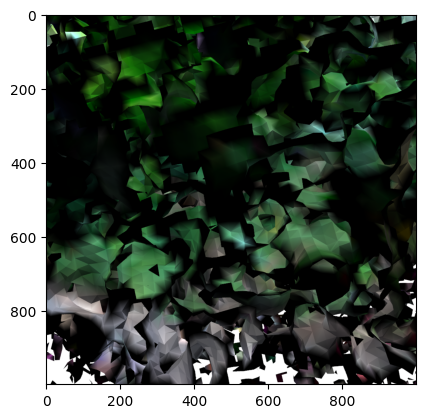

In [18]:
image = plotter.screenshot(
    window_size=(1000, 1000),
)

plt.imshow(image)